In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

# Set qubit parameters

In [72]:
# q_in, q_switch eg->gf

# EJs = [13.41, 12.52]
# ECs = [0.159, 0.183]
qubit_freqs = [3.646, 4.536]
alphas = [-0.159, -0.183]
gs = [0.025]

# Analytical swap

In [73]:
cutoffs = [4, 5]
isCavity = [False, False]

qram = QSwitch(
    # EJs=EJs,
    # ECs=ECs,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    gs=gs,
    cutoffs=cutoffs,
    is2Q=True,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)

# print('capacitances (fF)', *(qe**2/(2*h*np.array(qram.ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(qram.EJs)))

qubit freqs (GHz) 3.646 4.536
alphas (GHz) -0.159 -0.183


## Create pulse sequence

In [76]:
seq = PulseSequence(start_time=0)

print('wd1')
wd = qram.add_sequential_pi_pulse(seq, 'eg', 'gf', amp=0.12, drive_qubit=1)
analytical_sideband = 2*qubit_freqs[1]+alphas[1]-qubit_freqs[0]
print(f'Necessary drive frequency [MHz]: {1e3*wd/2/np.pi} vs. analytical: {1e3*analytical_sideband}: difference is [MHz] {(analytical_sideband - wd/2/np.pi)*1e3}')
print('Done.', flush=True)

wd1
	new overlap 0.6763226175073829 wd 32.95824178285312 wd_res 0.25
	new overlap 0.6763226175073829 wd 32.95824178285312 wd_res 0.05
	new overlap 0.9863919171177526 wd 32.93824178285312 wd_res 0.005
	new overlap 0.9863919171177526 wd 32.93824178285312 wd_res 0.001
	new overlap 0.9872075690766614 wd 32.93874178285312 wd_res 0.0001
	new overlap 0.987217041174917 wd 32.93870178285312 wd_res 2e-05
	new overlap 0.9872173727326228 wd 32.93869378285312 wd_res 4.000000000000001e-06
updated drive freq (GHz) from 5.245467095358916 to 5.242355934531355
Necessary drive frequency [MHz]: 5242.355934531356 vs. analytical: 5242.999999999999: difference is [MHz] 0.6440654686441505
Done.


[5.242355934531355] (GHz)
[407.5970109022613] (ns)
total pulse length 407.5970109022613 ns


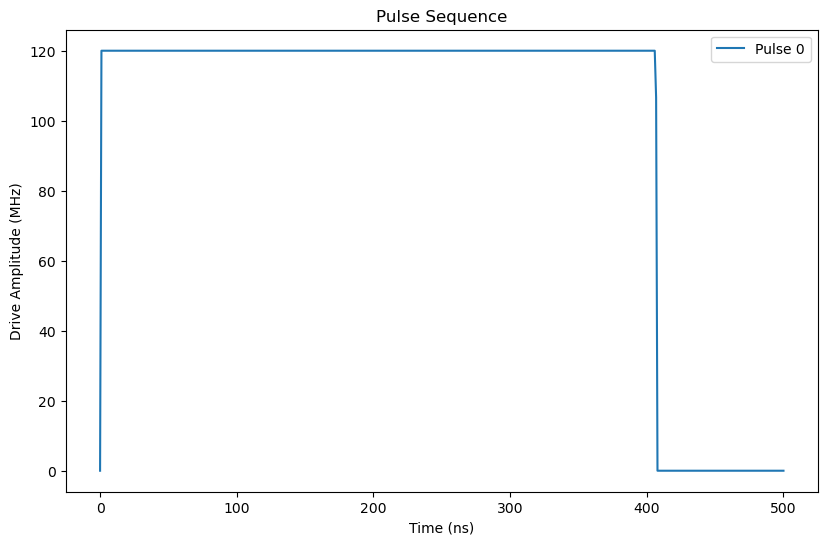

In [77]:
times = np.linspace(0, 500, 500)

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
for i in range(len(envelope_seq)):
    plt.plot(times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

## Run simulation

In [78]:
labframe = True
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
# ]

c_ops = None

In [79]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'
# psi0 = qram.state(psi0_name)

psi0 = np.sqrt(0.25) * qram.state('gf') + np.sqrt(0.75) * qram.state('eg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('eggg') + np.sqrt(0.75) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.25) * qram.state('gggg') + np.sqrt(0.75) * qram.state('gegg') # QRAM start

start_time = time.time()

print('Simulation in lab frame:', labframe)
if labframe:
    result = qram.evolve(psi0=psi0, seq=seq, times=times, c_ops=None, use_str_solve=False, nsteps=10000)
else:
    result = qram.evolve_rot_frame(psi0=psi0, seq=seq, times=times, nsteps=10000, c_ops=None)
print("Run time (s):", time.time() - start_time, flush=True)

Simulation in lab frame: True
10.0%. Run time:   0.92s. Est. time left: 00:00:00:08
20.0%. Run time:   1.82s. Est. time left: 00:00:00:07
30.0%. Run time:   2.83s. Est. time left: 00:00:00:06
40.0%. Run time:   3.71s. Est. time left: 00:00:00:05
50.0%. Run time:   4.75s. Est. time left: 00:00:00:04
60.0%. Run time:   5.70s. Est. time left: 00:00:00:03
70.0%. Run time:   6.60s. Est. time left: 00:00:00:02
80.0%. Run time:   7.49s. Est. time left: 00:00:00:01
90.0%. Run time:   8.31s. Est. time left: 00:00:00:00
Total run time:   9.09s
Run time (s): 9.090999364852905


eg probabilty 0.24831283853649028
gf probabilty 0.7425833542143978
gg probabilty 3.18172047474151e-06


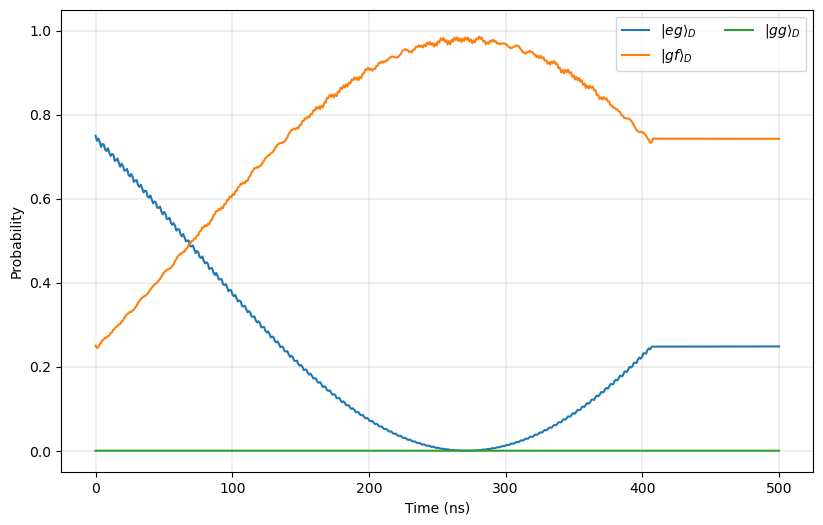

In [80]:
ref_states = ['eg', 'gf', 'gg']
for ref_state in ref_states:
    state = qram.state(ref_state)
    probs = [np.abs(state.overlap(result[t]))**2 for t in range(len(times))]
    print(ref_state, 'probabilty', probs[-1])
    plt.plot(times, probs, label=f'$|{ref_state}\\rangle_D$')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(ncol=2)
plt.ylim(-0.05, 1.05)
# plt.xlim(750, 1000)
# plt.tick_params(labelsize=12)
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()